In [1]:
# Librairies
import os
import sys
code_path = os.path.split(os.getcwd())[0]
sys.path.append(code_path)
import numpy as np
from scipy.sparse import load_npz
import seaborn as sns
import pandas as pd
from setting import *
from loader import *
from models import load_model
from graphs import *
from utils import *
from plots_and_stats import *
from clustering import *
from XAI_method import *
from XAI_interpret import prediction_gap_for_an_example, get_features_order

/projects/GraphNEx/anaconda3/envs/GraphNEx/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Arguments
name = "BRCA"
normalize_data = True
model_name = 'LR'
exp = 1
XAI_method = "Integrated_Gradients"
set_name = 'train'
normalize_XAI = True

In [3]:
# Path
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)
create_new_folder(os.path.join(save_path, model_name, f"exp_{exp}", XAI_method, "figures", set_name))

In [4]:
## To load results from another folder
# save_path = '/projects/GraphNEx/xai/XAI_for_genomics/Simulation/Results/SimuA/LR/exp_1/Integrated_Gradients'
# create_new_folder(os.path.join(save_path, "figures", set_name))
# create_new_folder('/projects/GraphNEx/xai/XAI_for_genomics/Simulation/Results/SimuA/LR/exp_1/graph')

In [5]:
# Load dataset
X_train, X_test, y_train, y_test, n_class, n_feat, class_name, feat_name = load_dataset(data_path, name, normalize_data, regroup=True)
# Keep only studied examples
_, studied_class = get_XAI_hyperparameters(name, n_class)
X_train = X_train[sum(y_train == c for c in studied_class).astype(bool)]
y_train = y_train[sum(y_train == c for c in studied_class).astype(bool)]
X_test = X_test[sum(y_test == c for c in studied_class).astype(bool)]
y_test = y_test[sum(y_test == c for c in studied_class).astype(bool)]
if set_name == "train":
    X = X_train
    y = y_train
elif set_name == "test":
    X = X_test
    y = y_test

44328 weakly expressed genes are removed of the dataset.


In [6]:
# Load explanations
attr, y_pred, y_true, _, _, baseline, baseline_pred = load_attributions(XAI_method, os.path.join(save_path, model_name, f"exp_{exp}", XAI_method), set_name=set_name)
if normalize_XAI:
    attr = transform_data(attr, transform='divide_by_norm')

In [7]:
# Only correctly classified examples are considered
indices = np.argwhere(y_pred == y_true).reshape(-1)
attr = attr[indices]
y_pred = y_pred[indices]
X = X[indices]
y = y[indices]
assert np.array_equal(y_pred, y)

In [8]:
# Load model
device = torch.device('cpu')
softmax = True
n_layer, n_hidden_feat, graph_name = get_hyperparameters(name, model_name)
model = load_model(model_name, n_feat, n_class, softmax, device, save_path, n_layer, 
                   n_hidden_feat, graph_name)

# Parameters
checkpoint = torch.load(os.path.join(save_path, os.path.join(model_name, f"exp_{exp}"), 'checkpoint.pt'))
model.load_state_dict(checkpoint['state_dict'])
model.eval()

LogisticRegression(
  (drop): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=13946, out_features=2, bias=True)
)

In [9]:
save_path = os.path.join(save_path, model_name, f"exp_{exp}", XAI_method)

# Describe data

In [10]:
n_class = len(class_name)
print(f"Number of classes: {n_class}\nNumber of variables: {X.shape[1]}\nNumber of samples: {X.shape[0]}")
for c in range(n_class):
    print(f"    Class {c} - {np.sum(y==c)}")

Number of classes: 2
Number of variables: 13946
Number of samples: 654
    Class 0 - 654
    Class 1 - 0


Average of the examples


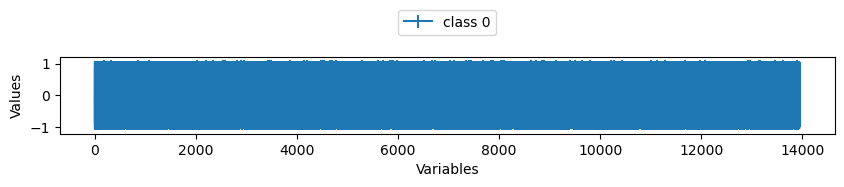

In [10]:
print("Average of the examples")
save_name = os.path.join(save_path, "figures", set_name, f"average_examples")
plot_average_signals(X, y, n_variable=X.shape[1], save_name=save_name)

Average of the attributions


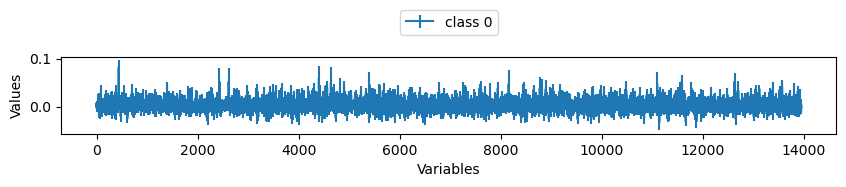

In [11]:
print("Average of the attributions")
save_name = os.path.join(save_path, "figures", set_name, f"average_attributions")
plot_average_signals(attr, y, n_variable=X.shape[1], save_name=save_name)

In [11]:
rand_ex = random.randint(0, X.shape[0] - 1)

Random example


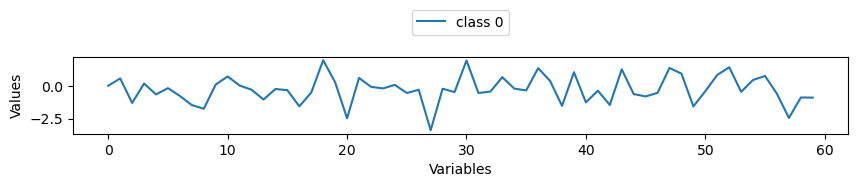

In [15]:
print("Random example")
save_name = os.path.join(save_path, "figures", set_name, f"random_example")
plot_random_signals(X[rand_ex].reshape(1, -1), y[rand_ex].reshape(1), n_sample_per_class=1, n_variable=60, save_name=save_name)

Random attribution


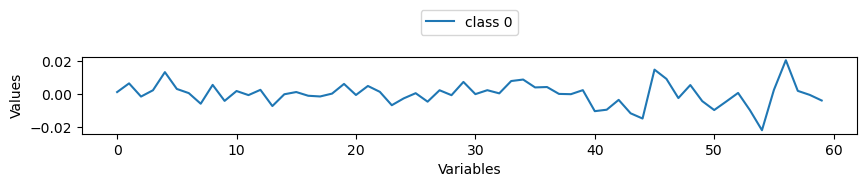

In [16]:
print("Random attribution")
save_name = os.path.join(save_path, "figures", set_name, f"random_attributions")
plot_random_signals(attr[rand_ex].reshape(1, -1), y[rand_ex].reshape(1), n_sample_per_class=1, n_variable=60, save_name=save_name)

# Show metrics

PGI: 98.6


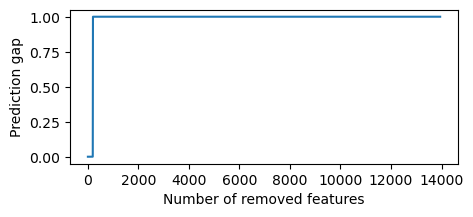

In [35]:
gap = 1
local_ordering = np.argsort(-attr[rand_ex].reshape(1, -1), axis=1)
transform = None
PG, curve = prediction_gap_for_an_example(model, torch.tensor(X[rand_ex].reshape(1, -1), dtype=torch.float32), 
                                          y[rand_ex], transform, gap, 
                                          torch.tensor(baseline), local_ordering)
print("PGI:", np.round(PG * 100, 2))
plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve) + 1) * gap, curve)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve)) * gap, np.array([n_feat]))), curve)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction gap")
plt.xlabel("Number of removed features")
plt.show()

PGU: 10.79


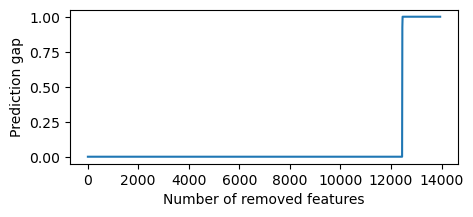

In [37]:
gap = 10
local_ordering = np.argsort(attr[rand_ex].reshape(1, -1), axis=1)
transform = None
PG, curve = prediction_gap_for_an_example(model, torch.tensor(X[rand_ex].reshape(1, -1), dtype=torch.float32), 
                                          y[rand_ex], transform, gap, 
                                          torch.tensor(baseline), local_ordering)
print("PGU:", np.round(PG * 100, 2))
plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve) + 1) * gap, curve)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve)) * gap, np.array([n_feat]))), curve)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction gap")
plt.xlabel("Number of removed features")
plt.show()

PGI: 99.0


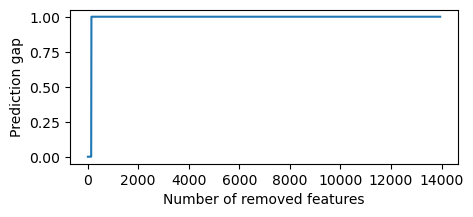

In [38]:
global_ordering = get_features_order(attr, _type="sum_decreasing").reshape(1, -1)
PG, curve = prediction_gap_for_an_example(model, torch.tensor(X[rand_ex].reshape(1, -1), dtype=torch.float32), 
                                          y[rand_ex], transform, gap, 
                                          torch.tensor(baseline), global_ordering)
print("PGI:", np.round(PG * 100, 2))
plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve) + 1) * gap, curve)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve)) * gap, np.array([n_feat]))), curve)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction gap")
plt.xlabel("Number of removed features")
plt.show()

PGU: 7.36


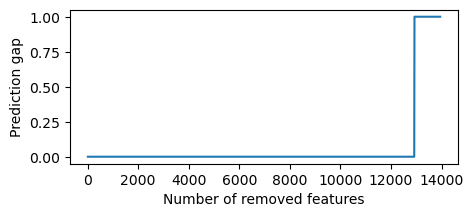

In [39]:
global_ordering = get_features_order(attr, _type="sum_increasing").reshape(1, -1)
PG, curve = prediction_gap_for_an_example(model, torch.tensor(X[rand_ex].reshape(1, -1), dtype=torch.float32), 
                                          y[rand_ex], transform, gap, 
                                          torch.tensor(baseline), global_ordering)
print("PGU:", np.round(PG * 100, 2))
plt.figure(figsize=(5, 2))
if n_feat % gap == 0:
    plt.plot(np.arange(1, len(curve) + 1) * gap, curve)
else:
    plt.plot(np.concatenate((np.arange(1, len(curve)) * gap, np.array([n_feat]))), curve)
plt.ylim(-0.05, 1.05)
plt.ylabel("Prediction gap")
plt.xlabel("Number of removed features")
plt.show()

# Show the attributions and the values of the first variables (local)

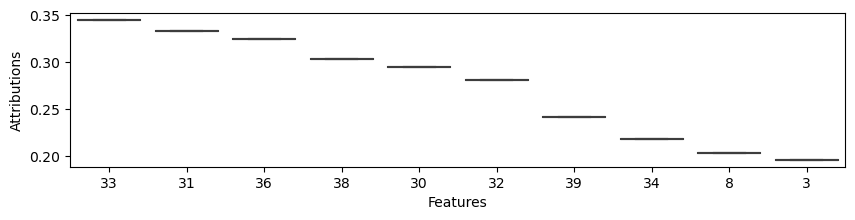

In [21]:
indices = np.argsort(-attr[rand_ex].reshape(1, -1), axis=1)
plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=attr[rand_ex, indices][0, :10], order=indices[0, :10])
plt.ylabel("Attributions")
plt.xlabel("Features")
plt.show()

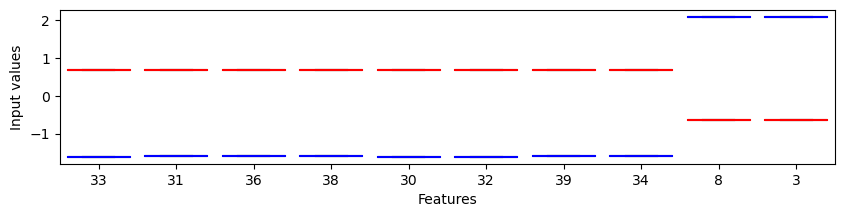

In [22]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=X[rand_ex][indices][0, :10], order=indices[0, :10], medianprops=dict(color='blue'))
sns.boxplot(x=indices[0, :10], y=baseline[0, indices][0, :10], order=indices[0, :10], medianprops=dict(color='red'))
plt.ylabel("Input values")
plt.xlabel("Features")
plt.show()

# Show the attributions and the values of the first variables (global)

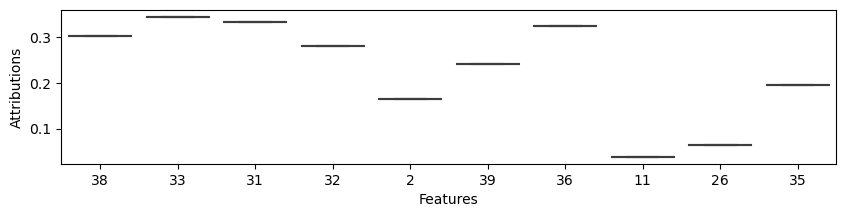

In [23]:
indices = get_features_order(attr, _type="sum_decreasing").reshape(1, -1)
plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=attr[rand_ex, indices][0, :10], order=indices[0, :10])
plt.ylabel("Attributions")
plt.xlabel("Features")
plt.show()

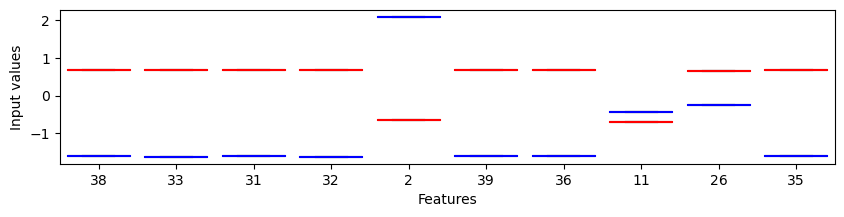

In [24]:
plt.figure(figsize=(10, 2))
sns.boxplot(x=indices[0, :10], y=X[rand_ex][indices][0, :10], order=indices[0, :10], medianprops=dict(color='blue'))
sns.boxplot(x=indices[0, :10], y=baseline[0, indices][0, :10], order=indices[0, :10], medianprops=dict(color='red'))
plt.ylabel("Input values")
plt.xlabel("Features")
plt.show()